In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn
from itertools import product
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e13/sample_submission.csv
/kaggle/input/playground-series-s3e13/train.csv
/kaggle/input/playground-series-s3e13/test.csv


## Import the data

### Train data

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e13/train.csv')
train_df.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


In [3]:
train_df.shape

(707, 66)

### Test data

In [4]:
test_df = pd.read_csv('/kaggle/input/playground-series-s3e13/test.csv')
test_df.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,708,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,709,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,710,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,711,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test_df.shape

(303, 65)

## Exploratory Data Analysis

### Check the labels distribution

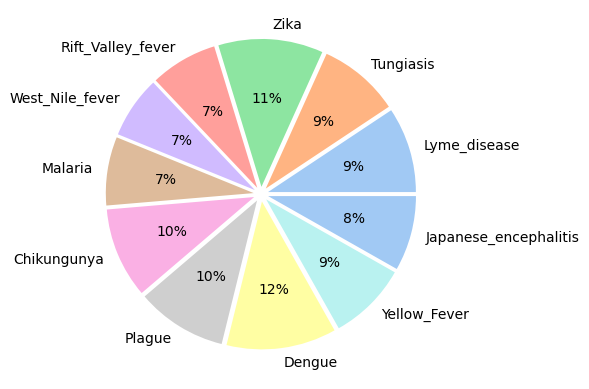

In [6]:
# declaring data
data = train_df.groupby(by='prognosis')['id'].count()
keys = train_df['prognosis'].unique()
  
# declaring exploding pie
explode = np.ones(len(data)) * 0.05
# define Seaborn color palette to use
palette_color = seaborn.color_palette('pastel')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color,
        explode=explode, autopct='%.0f%%')
  
# displaying chart
plt.show()

According to the graph we can see that all the label classes are somewhat equally distributed. 

### Define the MAP@K

In [7]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


## Baseline model development

### Encode the labels

In [8]:
# Encoder our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
train_df['prognosis'] = enc.fit_transform(train_df[['prognosis']])
train_df['prognosis'][:10] # Note the values here are now ordinal (floats)

0     3.0
1     7.0
2     3.0
3    10.0
4     6.0
5     3.0
6     8.0
7     7.0
8     4.0
9     0.0
Name: prognosis, dtype: float64

In [9]:
def top_3(prediction):
    sorted_prediction_ids = np.argsort(-prediction, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:, :3]
    
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1,1))
    top_3_predictions = top_3_predictions.reshape(top_3_prediction_ids.shape)
    
    return top_3_predictions
    

In [10]:
X = train_df.drop(columns='prognosis', axis=1)
y = train_df['prognosis']

In [11]:
kfold = KFold(n_splits=10, shuffle=True, random_state=100)
pred_xgb = np.zeros((test_df.shape[0], 11))


acc_xgb = []# list contains rmse for each fold
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    

    
    # XGBoost regressor
    model_xgb = XGBClassifier(objective = 'multi:softprob',
                          # tree_method = 'gpu_hist',
                           colsample_bytree = 0.6,  
                           gamma = 0.8,  
                           learning_rate = 0.01, 
                           max_depth = 5,
                           min_child_weight = 5, 
                           n_estimators = 500, 
                           subsample = 0.7).fit(x_train, y_train)
    
    pred_xgb+= model_xgb.predict_proba(test_df)/kfold.n_splits
    val_pred = top_3(model_xgb.predict_proba(x_valid))
    acc_xgb.append(mapk(y_valid.values.reshape(-1, 1), val_pred, k=3))
    

    print(f"fold: {n+1} MAP@3 XGB Classifier: {acc_xgb[n]}")
    n+=1
print(f"final MAP@3 is :{np.mean(acc_xgb)}")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



fold: 1 MAP@3 XGB Classifier: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



fold: 2 MAP@3 XGB Classifier: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



fold: 3 MAP@3 XGB Classifier: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



fold: 4 MAP@3 XGB Classifier: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



fold: 5 MAP@3 XGB Classifier: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



fold: 6 MAP@3 XGB Classifier: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



fold: 7 MAP@3 XGB Classifier: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



fold: 8 MAP@3 XGB Classifier: 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



fold: 9 MAP@3 XGB Classifier: 0.0
fold: 10 MAP@3 XGB Classifier: 0.0
final MAP@3 is :0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [12]:
top_3_pred_xgb = top_3(pred_xgb)

In [13]:
# top_3_pred_xgb

###  =================STILL WORKING ON OPTIMIZATION AND DECOMPOSITION==========================

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['prognosis'], 
#                                                     test_size=0.2, random_state=123) 

# acc_scores = []
# for i in range(1,train_df.shape[1]+1):
#     for j in range(20):
        
#         pipe = Pipeline([
#             ('scaler', StandardScaler()),
#             ('pca', PCA(n_components=i)),
#             ('rfc', RandomForestClassifier(random_state=0))])


#         pipe.fit(X_train, y_train)

#         accuracy = pipe.score(X_test, y_test)
#         acc_scores.append(accuracy)

   
# acc_scores = list(np.array(acc_scores).reshape(66,20))

# plt.figure(figsize=(20, 6))
# plt.boxplot(acc_scores, sym="")
# plt.xticks(rotation = 90)
# plt.xlabel('Number of Principle Components')
# plt.ylabel('Accuracy')
# plt.title('Model Accuracy with Increased Principle Components')
# plt.show()

In [15]:
# accuracy_score, num_features = 0.4, 66

# features_removed = [*range(1,101)]
# trail_mean = [a.mean() for a in acc_scores]

# features_mean = dict(zip(features_removed, trail_mean))
# res = {key:round(value,4) for (key,value) in features_mean.items() if (value > accuracy_score and key < num_features)}

# print(res)